# Data enrinchment with additional satellite data


This notebook provides a spatial overview and enrichment of the farm dataset, combining survey data with environmental and accessibility information. The main objectives are:

Visualizing farm locations: display farm points on an interactive map to explore their geographic distribution.

Extracting satellite and spatial data: retrieve NDVI, precipitation, and travel time to cities for each farm and for the entire study area using a proprietary API (Google Earth Engine).

Merging data: integrate the extracted spatial information with the merged farm dataset to create a comprehensive dataset for analysis.

Rasterizing survey data: convert the farm survey data into raster format across the study area, enabling spatially continuous inputs for modeling.

Disclaimers:

Accessing data from Google Earth Engine (GEE) requires a valid account and API credentials. Users must have these credentials to replicate the extraction process.

Although the rasters for the survey area were successfully prepared, I opted for an alternative approach in the subsequent modeling step. This workflow is presented here for informational purposes and to demonstrate the rasterization process.

This notebook provides a detailed overview of spatial data preparation and integration, serving as a reference for combining survey and environmental data in geospatial analyses.

Load libraries and data

In [31]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import ee
ee.Authenticate()
ee.Initialize(project='ee-obautista')
import geemap
import rasterio
from rasterio import features
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

FIrst we load the merged file exportef in the previous notebook.

In [32]:
merged = pd.read_csv('../Data/cleaned/merged_std.csv')

# Create GeoDataFrame from your coordinates
geometry = [Point(lon, lat) for lon, lat in zip(merged.longitude, merged.latitude)]
gdf = gpd.GeoDataFrame(merged, geometry=geometry, crs="EPSG:4326")

In [33]:
gdf.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   hhid                           100 non-null    int64   
 1   land_total_acres               100 non-null    float64 
 2   land_cultivated_acres          100 non-null    float64 
 3   maize_harvest_qty_kg           100 non-null    float64 
 4   maize_yield_ton_acre           100 non-null    float64 
 5   orgfert_qty_2024_kg_total_std  100 non-null    float64 
 6   livestock_owned_bin            100 non-null    int64   
 7   hh_head_education_class        100 non-null    int64   
 8   climate_info_received_num      100 non-null    int64   
 9   latitude                       100 non-null    float64 
 10  longitude                      100 non-null    float64 
 11  geometry                       100 non-null    geometry
dtypes: float64(7), geometry(1), i

Export the farm location data as GeoJSON, including only the hhid field and the coordinates in the exported file.

In [34]:
gdf_ids = gdf[['hhid','latitude','longitude','geometry']]
gdf_ids.to_file('../Data/spatial/farms.geojson')

Upload the geojson file with farm locations and ids to GEE

In [35]:
in_file = "../Data/spatial/farms.geojson"
in_fc = geemap.geojson_to_ee(in_file)


Next, show a map of the location of the farms in the dataset

In [36]:
# Visual exploration of the farms
fig = px.scatter_map(
    gdf,
    lat="latitude",
    lon="longitude",
    size= 'land_cultivated_acres',
    zoom=9,
    center={"lat": gdf.geometry.centroid.y.mean(), "lon": gdf.geometry.centroid.x.mean()},
    title='Farms'
)

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_layout(mapbox_style="carto-positron")
fig.show()

/var/folders/qx/9__482dx7kxchkqq764hl5z00000gq/T/ipykernel_3928/1222969754.py:8: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




The next step is to stack the satellite data (NDVI, precipitation) and grid data (travel time to cities) in GEE. 

The code below uses a single composite image for each variable as an example, although time series with multi-temporal data are also possible.

In [37]:
# Define analysis area
roi = ee.Geometry.Rectangle([34.41, -0.45, 35.09, 0.24])

# Load the pre-processed images (run previous scripts first)
precip_annual = ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD') \
    .filterDate('2024-01-01', '2024-12-31') \
    .select('precipitation').mean().rename('mean_rain')

greenest_pixel = ee.ImageCollection('MODIS/061/MOD13Q1') \
    .filterDate('2024-01-01', '2024-12-31') \
    .select('NDVI') \
    .qualityMosaic('NDVI').multiply(0.0001).rename('ndvi')

travel_time = ee.Image("Oxford/MAP/accessibility_to_cities_2015_v1_0").rename('travel_time')


# Create image stack
image_stack = ee.Image.cat([precip_annual, greenest_pixel, travel_time])

Then, extract and download the data from the image stack for each farm point, and save the result in the local drive

In [38]:
farm_enriched_path = "../Data/spatial/shp/farms_data.shp"
geemap.extract_values_to_points(in_fc, image_stack , farm_enriched_path)

farms_gee = gpd.read_file(farm_enriched_path)
farms_gee

Generating URL ...
Please wait ...
Data downloaded to /Volumes/T7/Github/Data-analysis-assignment/Data/spatial/shp/farms_data.shp


,mean_rain,latitude,travel_tim,ndvi,hhid,longitude,geometry
0,24.733860,-0.152069,55,0.7666,409,34.957133,POINT (34.95713 -0.15207)
1,24.733860,-0.065602,55,0.7666,398,34.603184,POINT (34.60318 -0.0656)
2,24.733860,-0.262380,55,0.7666,397,34.856136,POINT (34.85614 -0.26238)
3,25.628838,0.093717,33,0.7486,395,34.577614,POINT (34.57761 0.09372)
4,25.628838,0.072590,33,0.7486,389,34.685747,POINT (34.68575 0.07259)
...,...,...,...,...,...,...,...
95,24.733860,-0.032200,55,0.7666,15,34.924322,POINT (34.92432 -0.0322)
96,24.733860,-0.068037,55,0.7666,14,34.585810,POINT (34.58581 -0.06804)
97,25.628838,0.080369,33,0.7486,8,34.875563,POINT (34.87556 0.08037)
98,24.733860,-0.206509,55,0.7666,6,34.775973,POINT (34.77597 -0.20651)


In [39]:
farms_gee.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   mean_rain   100 non-null    float64 
 1   latitude    100 non-null    float64 
 2   travel_tim  100 non-null    int32   
 3   ndvi        100 non-null    float64 
 4   hhid        100 non-null    int32   
 5   longitude   100 non-null    float64 
 6   geometry    100 non-null    geometry
dtypes: float64(4), geometry(1), int32(2)
memory usage: 4.8 KB


Merge the enriched dataset with the original variables from the survey

In [40]:
#drop redundant variables in the entiched farms dataset (latitude, longitude, geometry)

farms_gee= farms_gee.drop(columns=['latitude','longitude', 'geometry'])


# Merge the pandas DataFrame into the GeoDataFrame
merged_gdf = gdf.merge(
    farms_gee,         # Right: pandas DataFrame
    on='hhid',          # Merge key
    how='inner'         # Keep only matching records
)
merged_gdf

,hhid,land_total_acres,land_cultivated_acres,maize_harvest_qty_kg,maize_yield_ton_acre,orgfert_qty_2024_kg_total_std,livestock_owned_bin,hh_head_education_class,climate_info_received_num,latitude,longitude,geometry,mean_rain,travel_tim,ndvi
0,409,2.50,0.50,135.0,0.27,1250.0,1,0,1,-0.152069,34.957133,POINT (34.95713 -0.15207),24.733860,55,0.7666
1,398,2.00,1.00,1350.0,1.35,600.0,1,1,1,-0.065602,34.603184,POINT (34.60318 -0.0656),24.733860,55,0.7666
2,397,1.50,1.25,180.0,0.14,600.0,1,3,1,-0.262380,34.856136,POINT (34.85614 -0.26238),24.733860,55,0.7666
3,395,3.00,2.00,2520.0,1.26,800.0,1,2,1,0.093717,34.577614,POINT (34.57761 0.09372),25.628838,33,0.7486
4,389,0.25,0.25,450.0,1.80,1250.0,1,2,1,0.072590,34.685747,POINT (34.68575 0.07259),25.628838,33,0.7486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,15,1.50,1.00,90.0,0.09,2400.0,1,1,0,-0.032200,34.924322,POINT (34.92432 -0.0322),24.733860,55,0.7666
96,14,1.00,1.00,20.0,0.02,2200.0,1,3,0,-0.068037,34.585810,POINT (34.58581 -0.06804),24.733860,55,0.7666
97,8,0.75,0.25,180.0,0.72,790.0,1,1,1,0.080369,34.875563,POINT (34.87556 0.08037),25.628838,33,0.7486
98,6,0.25,0.25,180.0,0.72,800.0,1,0,1,-0.206509,34.775973,POINT (34.77597 -0.20651),24.733860,55,0.7666


This dataset will be exported as it is the input for the spatial prediction model

In [41]:
merged_gdf.to_file('../Data/spatial/farms.geojson')

## 2. Preparation of additional dataset for spatial modelling after the probabilities are computed

Extract the values from ancialliary variables into in 1kmx1km mesh point dataset for the entire area of study

In [42]:
# Sample the image at regular points
sample_points = image_stack.sample(
    region=roi,
    scale=1113.2,  # 0.01° in meters (approx)
    projection='EPSG:4326',
    geometries=True
)

Export point mesh dataset from Google Earth Engine to the local machine

In [43]:
shp_var_path = '../Data/spatial/shp/grid_data.shp'
geemap.ee_export_vector(sample_points,shp_var_path ,verbose=True)

Generating URL ...
Please wait ...
Data downloaded to /Volumes/T7/Github/Data-analysis-assignment/Data/spatial/shp/grid_data.shp


Load the point grid mesh, add the coordinate and export as geojson

In [44]:
grid_data = gpd.read_file(shp_var_path)

# Assuming 'grid_data' is your GeoDataFrame
grid_data['longitude'] = grid_data.geometry.x
grid_data['latitude'] = grid_data.geometry.y
grid_data.info()
grid_data.to_file('../Data/spatial/grid_data_extended.geojson')


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4677 entries, 0 to 4676
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   mean_rain   4677 non-null   float64 
 1   travel_tim  4677 non-null   int32   
 2   ndvi        4677 non-null   float64 
 3   geometry    4677 non-null   geometry
 4   longitude   4677 non-null   float64 
 5   latitude    4677 non-null   float64 
dtypes: float64(4), geometry(1), int32(1)
memory usage: 201.1 KB


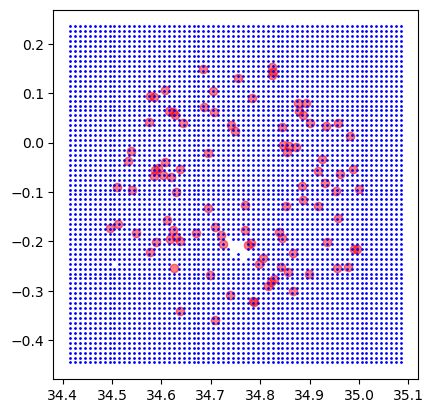

In [45]:
# Visual check
fig, ax = plt.subplots()
gdf.plot(ax=ax, color='red', alpha=0.5)
grid_data.plot(ax=ax, color='blue', markersize=1)
plt.show()

Next, create a function to rasterize the values from the columns; the unknown values are filled with the median to reduce their effect on the model

In [46]:


def rasterize_cols (gdf, column_name, tif_path, fill):


    # Define the bounding box and resolution
    bbox = [34.41, -0.45, 35.09, 0.24]  # [west, south, east, north]
    scale = 0.01  # degrees

    # Calculate dimensions
    width = int((bbox[2] - bbox[0]) / scale)
    height = int((bbox[3] - bbox[1]) / scale)

    # Create transform
    transform = rasterio.transform.from_bounds(*bbox, width, height)

    # Create shapes with actual values from your column
    shapes = [(geom, value) for geom, value in zip(gdf.geometry, gdf[column_name])]

    # Rasterize with actual values
    rasterized = features.rasterize(
        shapes,
        out_shape=(height, width),
        transform=transform,
        fill= fill, # fill non-farm areas with median
        dtype=np.float32  # use float to handle decimal values
    )

    # Save output
    with rasterio.open(
        tif_path,
        'w',
        driver='GTiff',
        height=height,
        width=width,
        count=1,
        dtype=rasterio.float32,
        crs=gdf.crs,
        transform=transform,
        nodata= fill 
    ) as dst:
        dst.write(rasterized, 1)

    print(f"Raster created with actual values from column: '{column_name}'")

In [47]:
merged.columns

Index(['hhid', 'land_total_acres', 'land_cultivated_acres',
       'maize_harvest_qty_kg', 'maize_yield_ton_acre',
       'orgfert_qty_2024_kg_total_std', 'livestock_owned_bin',
       'hh_head_education_class', 'climate_info_received_num', 'latitude',
       'longitude'],
      dtype='object')

In this step,  define the values that the rasterizing function will use, specifying both the variable to rasterize and the values for areas with no data. 

This example uses the median value of each variable for simplicity and given the small number of farm data points; more robust geostatistical methods, such as kriging, inverse distance weighting (IDW), spline interpolation, or co-kriging, can also be applied.

In [48]:
# column to rasterize
column_name = 'land_cultivated_acres' 
column_name = 'maize_harvest_qty_kg'
column_name = 'maize_yield_ton_acre'  
column_name = 'orgfert_qty_2024_kg_total' 

#output tiff paths

tif_path ='../Data/spatial/grid/cult_acr.tif'
tif_path ='../Data/spatial/grid/maize_kg.tif'
tif_path ='../Data/spatial/grid/maize_y.tif'
tif_path ='../Data/spatial/grid/fert_kg.tif'

# mean of each column
fill = 1.00
fill = 360
fill = 0.37
fill = 1250

Apply the rasterize funtion to each variable

In [49]:
rasterize_cols(gdf,'land_cultivated_acres','../Data/spatial/grid/cult_acr.tif',1.00)
rasterize_cols(gdf,'maize_harvest_qty_kg','../Data/spatial/grid/maize_kg.tif',360)
rasterize_cols(gdf,'maize_yield_ton_acre','../Data/spatial/grid/maize_y.tif',0.37)
rasterize_cols(gdf,'orgfert_qty_2024_kg_total_std','../Data/spatial/grid/fert_kg.tif',1250)
rasterize_cols(gdf,'livestock_owned_bin','../Data/spatial/grid/livestock.tif',1)
rasterize_cols(gdf,'hh_head_education_class','../Data/spatial/grid/hh_edu.tif',2)

Raster created with actual values from column: 'land_cultivated_acres'
Raster created with actual values from column: 'maize_harvest_qty_kg'
Raster created with actual values from column: 'maize_yield_ton_acre'
Raster created with actual values from column: 'orgfert_qty_2024_kg_total_std'
Raster created with actual values from column: 'livestock_owned_bin'
Raster created with actual values from column: 'hh_head_education_class'


Perform a visual check of one of the resulting files, using a logarithmic scale to better distinguish the farm pixels.

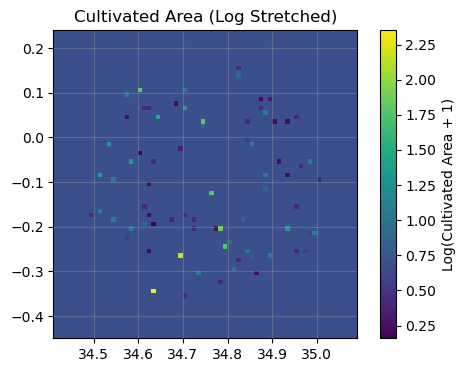

In [50]:

#load the raster
with rasterio.open('../Data/spatial/grid/cult_acr.tif') as src:
    data = src.read(1)
    bounds = src.bounds

# Apply logarithmic stretch to enhance low values
data_stretched = np.log1p(data)  # log(1 + x) to handle zeros
#generate the plot
plt.figure(figsize=(6, 4))
plt.imshow(data_stretched, extent=[bounds.left, bounds.right, bounds.bottom, bounds.top], 
           cmap='viridis', origin='upper')
plt.colorbar(label='Log(Cultivated Area + 1)')
plt.title('Cultivated Area (Log Stretched)')
plt.grid(True, alpha=0.3)
plt.show()

Sample the rasters derived from the merged dataset to get information from the surveys for the model

In [51]:

# 1. Load your pre-existing grid data

print(f"Grid data shape: {grid_data.shape}")
print(f"Grid data columns: {list(grid_data.columns)}")

# If it's a GeoDataFrame with geometry, extract coordinates:
if hasattr(grid_data, 'geometry'):
    grid_data['longitude'] = grid_data.geometry.x
    grid_data['latitude'] = grid_data.geometry.y
    
# Define folder containing TIFF files
tiff_folder = '../Data/spatial/grid/'

# Extract values from all TIFF files
for filename in os.listdir(tiff_folder):
    if filename.endswith('.tif') or filename.endswith('.tiff'):
        # Remove extension to get column name
        col_name = os.path.splitext(filename)[0]
        tiff_path = os.path.join(tiff_folder, filename)
        
        print(f"Processing: {filename} -> Column: {col_name}")
        
        try:
            with rasterio.open(tiff_path) as src:
                # Extract values for all grid points
                values = []
                for idx, row in grid_data.iterrows():
                    # Convert lat/lon to raster row/col indices
                    row_idx, col_idx = src.index(row['longitude'], row['latitude'])
                    try:
                        # Read value at this position (first band)
                        value = src.read(1)[row_idx, col_idx]
                        values.append(value)
                    except IndexError:
                        # If point is outside raster bounds, use NaN
                        values.append()
            
            # Add extracted values as new column
            grid_data[col_name] = values
            
        except Exception as e:
            print(f"Error processing {filename}: {e}")
            continue

Grid data shape: (4677, 6)
Grid data columns: ['mean_rain', 'travel_tim', 'ndvi', 'geometry', 'longitude', 'latitude']
Processing: cult_acr.tif -> Column: cult_acr
Processing: maize_kg.tif -> Column: maize_kg
Processing: maize_y.tif -> Column: maize_y
Processing: fert_kg.tif -> Column: fert_kg
Processing: livestock.tif -> Column: livestock
Processing: hh_edu.tif -> Column: hh_edu


In [52]:
grid_data.describe(include='all')

,mean_rain,travel_tim,ndvi,geometry,longitude,latitude,cult_acr,maize_kg,maize_y,fert_kg,livestock,hh_edu
count,4677.000000,4677.000000,4677.000000,4677,4677.000000,4677.000000,4677.000000,4677.000000,4677.000000,4677.000000,4677.000000,4677.000000
unique,NaN,NaN,NaN,4677,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,POINT (34.46515765262401 -0.4450020355554239),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,27.581481,33.066282,0.664774,NaN,34.750254,-0.104628,1.009618,364.287781,0.373102,1258.846436,0.997434,1.994227
std,4.152267,24.820586,0.275856,NaN,0.196563,0.199395,0.236451,89.567116,0.068888,190.356125,0.050594,0.194472
min,14.527000,0.000000,-0.188200,NaN,34.415157,-0.445002,0.173241,20.000000,0.020000,20.000000,0.000000,0.000000
25%,24.885387,16.000000,0.716200,NaN,34.575158,-0.275001,1.000000,360.000000,0.370000,1250.000000,1.000000,2.000000
50%,26.868463,27.000000,0.774200,NaN,34.755159,-0.105000,1.000000,360.000000,0.370000,1250.000000,1.000000,2.000000
75%,30.495197,43.000000,0.803600,NaN,34.925160,0.065000,1.000000,360.000000,0.370000,1250.000000,1.000000,2.000000


Export the geospatial json file

In [53]:
gdf.to_file('../Data/spatial/farms_merged_vals.geojson')

The analysis continues in the notebook 5_spatial_model.ipynb